In [1]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial
import importlib
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np

In [180]:
b3d.rr_init("slam")

In [156]:
room_h, room_w = 1.0, 1.0
line_segments = jnp.array(
    [
        [0.0, 0.0, room_w, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0, room_h, 0.0, 1.0, 0.0],
        [room_w, 0.0, room_w, room_h, 0.0, 0.0, 1.0],
        [0.0, room_h, room_w, room_h, 1.0, 1.0, 0.0],
    ]
)
epsilon = 0.003
line_segments = jnp.concatenate(
    [
        line_segments,
        line_segments
        + jnp.array([room_w + epsilon, 0.0, room_w + epsilon, 0.0, 0.0, 0.0, 0.0]),
        line_segments
        + jnp.array(
            [
                (room_w + epsilon) * 2.0,
                0.0,
                (room_w + epsilon) * 2.0,
                0.0,
                0.0,
                0.0,
                0.0,
            ]
        ),
    ],
    axis=0,
)
world_height = 0.5


def line_segment_to_mesh(line_segment):
    a, b, c, d, r1, g1, b1 = line_segment
    vertices = jnp.array(
        [
            [a, world_height / 2, b],
            [a, -world_height / 2, b],
            [c, -world_height / 2, d],
            [c, world_height / 2, d],
        ]
    )
    faces = jnp.array(
        [
            [0, 1, 3],
            [3, 1, 2],
        ]
    )
    vertex_attributes = jnp.ones((len(vertices), 3)) * jnp.array([r1, g1, b1])
    return Mesh(vertices, faces, vertex_attributes)


world_mesh = Mesh.squeeze_mesh(jax.vmap(line_segment_to_mesh)(line_segments))
world_mesh.rr_visualize("mesh")

In [157]:
renderer = b3d.renderer.renderer_original.RendererOriginal()

In [271]:
import functools

import jax
import jax.numpy as jnp


def log_gaussian_kernel(size: int, sigma: float) -> jnp.ndarray:
    """Creates a 2D Gaussian kernel."""
    ax = jnp.arange(-size // 2 + 1.0, size // 2 + 1.0)
    xx, yy = jnp.meshgrid(ax, ax)
    kernel = -(xx**2 + yy**2) / (2.0 * sigma**2)
    kernel = kernel - jax.nn.logsumexp(kernel)
    return kernel


@jax.jit
def intermediate_likelihood_func(observed_rgbd, latent_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    color_variance = likelihood_args["color_variance_0"]
    depth_variance = likelihood_args["depth_variance_0"]
    blur = likelihood_args["blur"]
    outlier_probability = likelihood_args["outlier_probability_0"]

    ###########
    @functools.partial(
        jnp.vectorize,
        signature="(m)->()",
        excluded=(
            1,
            2,
            3,
            4,
        ),
    )
    def per_pixel(
        ij,
        observed_rgbd,
        latent_rgbd_padded,
        log_kernel,
        filter_size,
    ):
        latent_rgb_padded_window = jax.lax.dynamic_slice(
            latent_rgbd_padded,
            (ij[0], ij[1], 0),
            (2 * filter_size + 1, 2 * filter_size + 1, 4),
        )
        scores_inlier = genjax.truncated_normal.logpdf(
            observed_rgbd[ij[0], ij[1], :],
            latent_rgb_padded_window,
            jnp.array([color_variance, color_variance, color_variance, depth_variance]),
            0.0,
            1.0,
        ).sum(-1)
        return jax.nn.logsumexp(scores_inlier + log_kernel)

    filter_size = 10

    @jax.jit
    def likelihood_per_pixel(
        observed_rgbd: jnp.ndarray, latent_rgbd: jnp.ndarray, blur
    ):
        latent_rgbd_padded = jnp.pad(
            latent_rgbd,
            (
                (filter_size, filter_size),
                (filter_size, filter_size),
                (0, 0),
            ),
            mode="edge",
        )
        jj, ii = jnp.meshgrid(
            jnp.arange(observed_rgbd.shape[1]), jnp.arange(observed_rgbd.shape[0])
        )
        indices = jnp.stack([ii, jj], axis=-1)

        log_kernel = log_gaussian_kernel(2 * filter_size + 1, blur)

        log_probabilities = per_pixel(
            indices,
            observed_rgbd,
            latent_rgbd_padded,
            log_kernel,
            filter_size,
        )
        return log_probabilities

    pixelwise_score = likelihood_per_pixel(
        observed_rgbd, latent_rgbd, likelihood_args["blur"]
    )
    return {
        "score": pixelwise_score.mean() * k,
        "observed_color_space_d": observed_rgbd,
        "latent_color_space_d": latent_rgbd,
        "pixelwise_score": pixelwise_score,
    }


import b3d.chisight.dense.dense_model

b3d.reload(b3d.chisight.dense.dense_model)
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func
    )
)
importance_jit = jax.jit(model.importance)


grid3 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True)
)
grid4 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True, True)
)

In [277]:
IDX = 4
likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "k": Pytree.const(100),
}

gt_camera_pose = Pose.from_translation(jnp.array([0.81, 0.0, 0.21]))
rgbd = renderer.render_rgbd_from_mesh(world_mesh.transform(gt_camera_pose.inv()))

latent_camera_pose = Pose.from_translation(jnp.array([0.84, 0.0, 0.21]))
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "camera_pose": latent_camera_pose,
        "object_pose_0": Pose.identity(),
        "color_variance_0": 0.1,
        "depth_variance_0": 0.1,
    }
)

key = jax.random.PRNGKey(0)
trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]
print(trace.get_score())
viz_trace(trace)
info = info_from_trace(trace)

748.9908


In [281]:
# outlier_probability_sweep = jnp.linspace(0.001, 0.2, 30)
color_variance_sweep = jnp.linspace(0.05, 0.3, 20)
depth_variance_sweep = jnp.linspace(0.05, 0.3, 15)
blur_sweep = jnp.linspace(0.01, 10.0, 20)

arguments = Pytree.const(
    (
        "color_variance_0",
        "depth_variance_0",
        "blur",
    )
)
sweeps = [
    color_variance_sweep,
    depth_variance_sweep,
    blur_sweep,
]

key = jax.random.split(key, 2)[-1]

# arguments = Pytree.const(("outlier_probability_background", "lightness_variance_background", "color_variance_background", "depth_variance_background",))

scores = grid3(trace, key, arguments, *sweeps)
sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
    jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
)
sampled_parameters = jnp.vstack(
    [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
).T

print(sampled_parameters[0])
trace = b3d.update_choices(
    trace,
    key,
    arguments,
    # 0.05, 1.0, 0.02, 0.01
    *sampled_parameters[0],
)
print(trace.get_score())
viz_trace(trace)
info_from_trace(trace)["score"]

[0.05      0.05      2.6389472]
1020.5025


Array(1037.1581, dtype=float32)

In [286]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 2.5
wz = 3.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)

[635 643 651] [165 249 586]


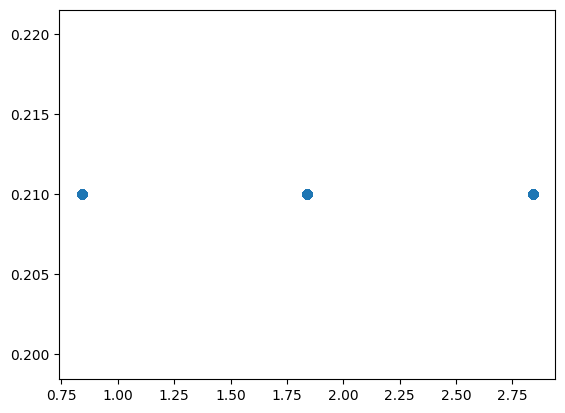

In [287]:
sampled_indices = jax.random.categorical(key, scores * 0.2, shape=(1000,))

sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [204]:
blur_sweep

Array([ 0.01     ,  0.5357895,  1.061579 ,  1.5873685,  2.113158 ,
        2.6389472,  3.164737 ,  3.6905265,  4.2163157,  4.7421055,
        5.2678947,  5.7936845,  6.3194737,  6.8452635,  7.371053 ,
        7.8968425,  8.422632 ,  8.9484215,  9.474211 , 10.       ],      dtype=float32)

In [ ]:
observed_camera_pose = Pose.from_translation(jnp.array([0.81, 0.0, 0.21]))
latent_camera_pose = Pose.from_translation(jnp.array([0.83, 0.0, 0.21]))
observed_rgb = renderer.render_rgbd_from_mesh(
    world_mesh.transform(observed_camera_pose.inv())
)[..., :3]
latent_rgb = renderer.render_rgbd_from_mesh(
    world_mesh.transform(latent_camera_pose.inv())
)[..., :3]

b3d.rr_log_rgb("image", observed_rgb)
b3d.rr_log_rgb("image/latent", latent_rgb)

scores = likelihood_vmap_blur(observed_rgb, latent_rgb, {"blur": blur_sweep})
print(scores)
# b3d.rr_log_depth("b", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01))
# b3d.rr_log_depth("b/higher_noise", likelihood_per_pixel(observed_rgb, latent_rgb, 10.0))
# # b3d.rr_log_depth("b/diff", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01) - likelihood_per_pixel(observed_rgb, latent_rgb, 1.0))

# blur_sweep = jnp.linspace(0.01, 10.5, 100)
# scores = likelihood_vmap_blur(observed_rgb, latent_rgb, blur_sweep)
# print(blur_sweep[scores.argmax()])
# plt.plot(blur_sweep, scores)

15.189407


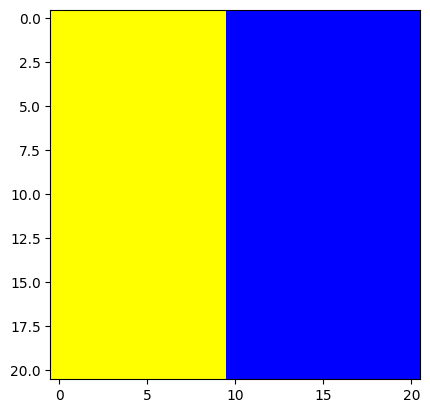

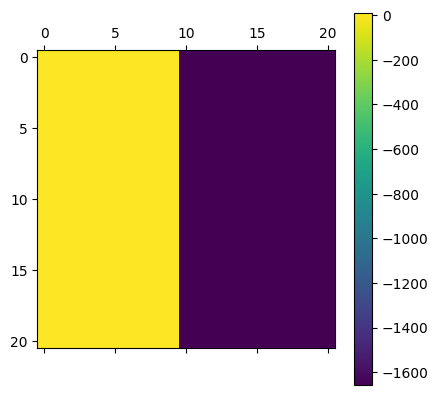

In [144]:
latent_rgb_padded = jnp.pad(
    latent_rgb,
    (
        (filter_size, filter_size),
        (filter_size, filter_size),
        (0, 0),
    ),
    mode="edge",
)
jj, ii = jnp.meshgrid(
    jnp.arange(observed_rgb.shape[1]), jnp.arange(observed_rgb.shape[0])
)
indices = jnp.stack([ii, jj], axis=-1)
ij = jnp.array([54, 65])


latent_rgb_padded_window = jax.lax.dynamic_slice(
    latent_rgb_padded,
    (ij[0], ij[1], 0),
    (2 * filter_size + 1, 2 * filter_size + 1, 3),
)
scores_inlier = genjax.truncated_normal.logpdf(
    observed_rgb[ij[0], ij[1], :], latent_rgb_padded_window, 0.03, 0.0, 1.0
).sum(-1)
plt.imshow(latent_rgb_padded_window)
plt.matshow(scores_inlier)
plt.colorbar()

blur = 0.01
log_kernel = gaussian_kernel(2 * filter_size + 1, blur)
averaged_prob = jax.nn.logsumexp(jax.nn.logsumexp(scores_inlier + log_kernel))
averaged_prob = jax.nn.logsumexp(jax.nn.logsumexp(scores_inlier + log_kernel))
print(averaged_prob)

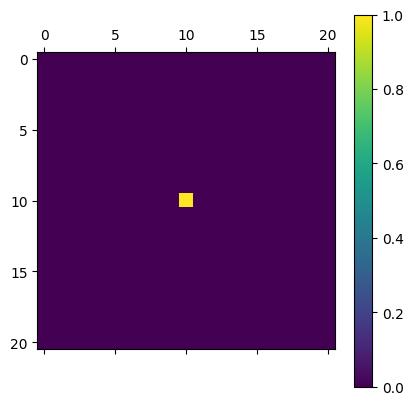

In [148]:
plt.matshow(log_kernel)
plt.colorbar()

-1656.8243


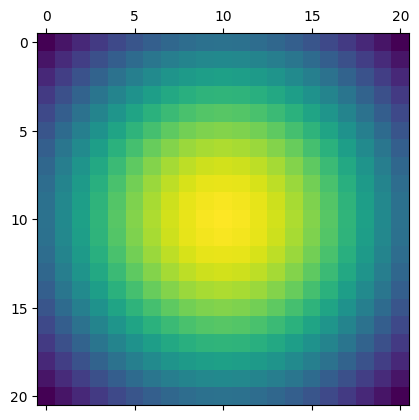

In [133]:
print(
    genjax.truncated_normal.logpdf(
        jnp.array([1.0, 1.0, 0.0]), jnp.array([0.0, 0.0, 1.0]), 0.03, 0.0, 1.0
    ).sum(-1)
)

log_kernel = gaussian_kernel(2 * filter_size + 1, blur)
plt.matshow(log_kernel)

In [130]:
b3d.rr_log_depth("b", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01))
b3d.rr_log_depth("b/higher_noise", likelihood_per_pixel(observed_rgb, latent_rgb, 10.0))
# b3d.rr_log_depth("b/diff", likelihood_per_pixel(observed_rgb, latent_rgb, 0.01) - likelihood_per_pixel(observed_rgb, latent_rgb, 1.0))

-2696.628
0.9999998


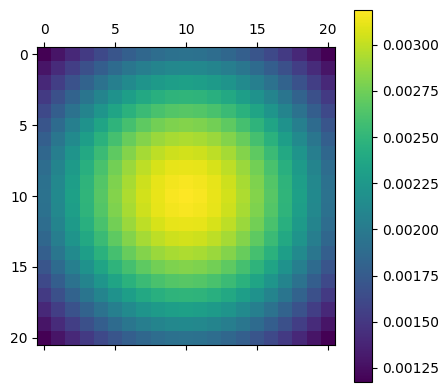

In [127]:
blur = 10.0
kernel = log_gaussian_kernel(2 * filter_size + 1, blur)
print(kernel.sum())
plt.matshow(jnp.exp(kernel))
plt.colorbar()
print(jnp.exp(kernel).sum())

In [16]:
lower_bound = jnp.array([0.0, 0.0, 0.0, 0.0])
upper_bound = jnp.array([1.0, 1.0, 1.0, 3.0])
convert_rgbd_to_color_space = lambda x: x
convert_color_space_to_rgbd = lambda x: x


# convert_rgbd_to_color_space = lambda x: b3d.colors.rgbd_to_labd(x)
# convert_color_space_to_rgbd = lambda x: b3d.colors.labd_to_rgbd(x)
def intermediate_likelihood_func(observed_rgbd, latent_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    fx = likelihood_args["fx"]
    fy = likelihood_args["fy"]

    outlier_probability_0 = likelihood_args[f"outlier_probability_0"]
    # lightness_variance_0 = likelihood_args[f"lightness_variance_0"]
    color_variance_0 = likelihood_args[f"color_variance_0"]
    # depth_variance_0 = likelihood_args[f"depth_variance_0"]

    inlier_variances_0 = jnp.array(
        [color_variance_0, color_variance_0, color_variance_0, color_variance_0]
    )
    outlier_variances = jnp.array([1000000.0, 1000000.0, 1000000.0, 1000000.0])

    image_height, image_width = observed_rgbd.shape[:2]

    blur = likelihood_args["blur"]
    observed_color_space_d = apply_gaussian_blur_rgbd(
        observed_rgbd[..., :3], blur, kernel_size
    )
    latent_color_space_d = apply_gaussian_blur_rgbd(observed_rgb, blur, kernel_size)

    scores_inlier = genjax.truncated_normal.logpdf(
        observed_color_space_d, latent_color_space_d, color_variance_0, 0.0, 1.0
    ) + jnp.log(1.0 - outlier_probability_0)
    scores_outlier = genjax.truncated_normal.logpdf(
        observed_color_space_d, 0.5, 0.1, 0.0, 1.0
    ) + jnp.log(outlier_probability_0)
    print(scores_inlier.shape)
    print(scores_outlier.shape)

    return {
        "score": pixelwise_score.sum(),
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score,
    }

    # subset_observed = observed_color_space_d
    # subset_observed_rescaled = (subset_observed - lower_bound) / (
    #     upper_bound - lower_bound
    # )
    # rendered_values_rescaled = (latent_color_space_d - lower_bound) / (
    #     upper_bound - lower_bound
    # )

    # scores_inlier = jax.vmap(
    #     genjax.truncated_normal.logpdf, in_axes=(0, 0, None, None, None)
    # )(subset_observed_rescaled, rendered_values_rescaled, inlier_variances_0, 0.0, 1.0)
    # scores_outlier = jax.vmap(
    #     genjax.truncated_normal.logpdf, in_axes=(0, None, None, None, None)
    # )(subset_observed_rescaled, 0.5, outlier_variances, 0.0, 1.0)

    # scores_inlier_merged = scores_inlier[..., :3].sum(-1) + jnp.log(
    #     1.0 - outlier_probability_0
    # )
    # scores_outlier_merged = scores_outlier[..., :3].sum(-1) + jnp.log(
    #     outlier_probability_0
    # )

    # pixelwise_score = jnp.logaddexp(scores_inlier_merged, scores_outlier_merged)
    # pixelwise_score_full = jnp.zeros((image_height, image_width))
    # pixelwise_score_full = pixelwise_score

    return {
        "score": pixelwise_score_full.sum(),
        # "score": (
        #     jax.nn.logsumexp(pixelwise_score_full) - jnp.log(pixelwise_score_full.size)
        # )
        # * k,
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score_full,
    }


import b3d.chisight.dense.dense_model

b3d.reload(b3d.chisight.dense.dense_model)
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, intermediate_likelihood_func
    )
)
importance_jit = jax.jit(model.importance)


grid1 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True))
grid2 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True, True))
grid3 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True)
)
grid4 = b3d.multivmap(
    b3d.update_choices_get_score, (False, False, False, True, True, True, True)
)

In [32]:
IDX = 4
key = jax.random.PRNGKey(0)
likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "k": Pytree.const(50),
}

T = 22
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": rgbd,
        "object_pose_0": Pose.identity(),
        "camera_pose": Pose.from_translation(
            gt_camera_pose.pos + jnp.array([0.1, 0.0, -0.01])
        ),
        # "outlier_probability_0": 0.1,
        # "color_variance_0": 0.2,
    }
)

trace = importance_jit(
    key,
    choicemap,
    (
        {
            "num_objects": Pytree.const(1),
            "meshes": [world_mesh],
            "likelihood_args": likelikood_args,
        },
    ),
)[0]
print(trace.get_score())
viz_trace(trace)

13398.95


[641] [1000]


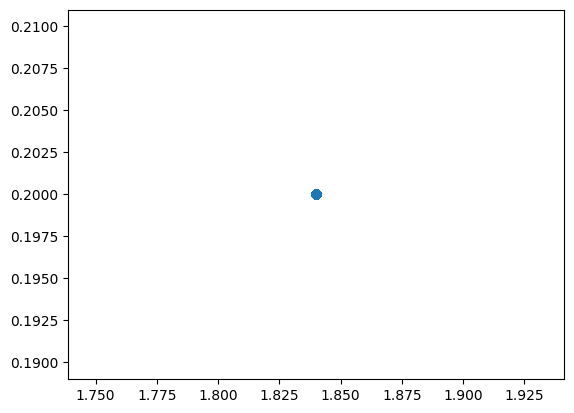

In [34]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 3.1
wz = 1.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)
sampled_indices = jax.random.categorical(key, scores, shape=(1000,))

# print(sampled_indices)
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

In [ ]:
plt.scatter(poses.pos[:, 0], poses.pos[:, 2], c=scores)
plt.colorbar()

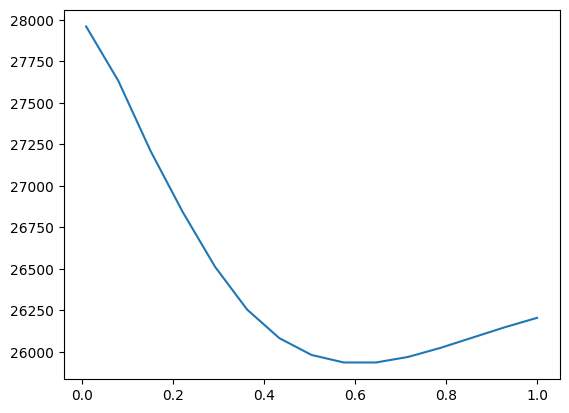

In [397]:
scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("blur",)),
    blur_sweep,
)
plt.plot(blur_sweep, scores)

In [33]:
outlier_probability_sweep = jnp.linspace(0.001, 0.2, 30)
color_variance_sweep = jnp.linspace(0.1, 0.3, 15)
blur_sweep = jnp.linspace(0.01, 1.0, 15)

for arguments in [
    Pytree.const(
        (
            "outlier_probability_background",
            "color_variance_background",
        )
    ),
]:
    key = jax.random.split(key, 2)[-1]

    # arguments = Pytree.const(("outlier_probability_background", "lightness_variance_background", "color_variance_background", "depth_variance_background",))
    sweeps = [
        outlier_probability_sweep,
        color_variance_sweep,
        # blur_sweep,
    ]

    scores = grid2(trace, key, arguments, *sweeps)
    sampled_indices = jax.vmap(jnp.unravel_index, in_axes=(0, None))(
        jax.random.categorical(key, scores.reshape(-1), shape=(1000,)), scores.shape
    )
    sampled_parameters = jnp.vstack(
        [sweep[indices] for indices, sweep in zip(sampled_indices, sweeps)]
    ).T

    print(sampled_parameters[0])
    trace = b3d.update_choices(
        trace,
        key,
        arguments,
        # 0.05, 1.0, 0.02, 0.01
        *sampled_parameters[0],
    )
    print(trace.get_score())
    viz_trace(trace)
    info_from_trace(trace)["score"]

[0.09706897 0.24285716]
13398.95


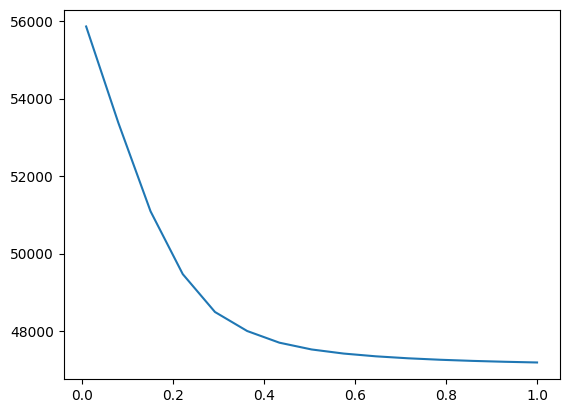

In [316]:
scores = b3d.enumerate_choices_get_scores(
    trace,
    key,
    Pytree.const(("blur",)),
    blur_sweep,
)
plt.plot(blur_sweep, scores)

In [1]:
import jax.random

key = b3d.split_key(key)

gt_translation = trace.get_choices()["camera_pose"].pos
w = 3.1
wz = 1.0
grid = b3d.utils.make_grid_points(
    jnp.array([gt_translation[0] - w, gt_translation[1], gt_translation[2] - wz]),
    jnp.array([gt_translation[0] + w, gt_translation[1], gt_translation[2] + wz]),
    jnp.array([41, 1, 31]),
)
poses = Pose.from_translation(grid)
address = Pytree.const(("camera_pose",))
scores = grid1(trace, key, Pytree.const(("camera_pose",)), poses)
sampled_indices = jax.random.categorical(key, scores, shape=(1000,))

# print(sampled_indices)
sampled_indices_unique, counts = jnp.unique(sampled_indices, return_counts=True)
sampled_pose = poses[sampled_indices[0]]
print(sampled_indices_unique, counts)
sampled_trace = b3d.update_choices(trace, key, address, sampled_pose)
viz_trace(sampled_trace)

plt.scatter(grid[sampled_indices, 0], grid[sampled_indices, 2], alpha=0.5)

NameError: name 'b3d' is not defined

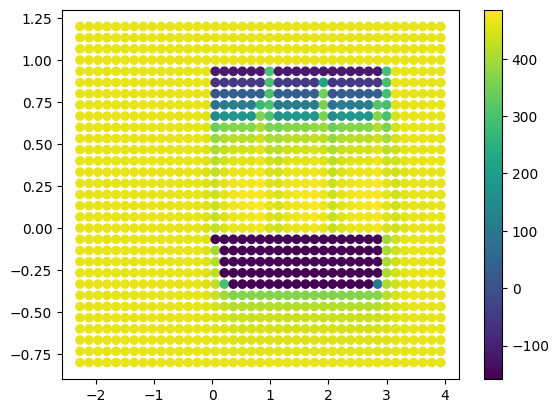

In [200]:
plt.scatter(poses.pos[:, 0], poses.pos[:, 2], c=scores)
plt.colorbar()

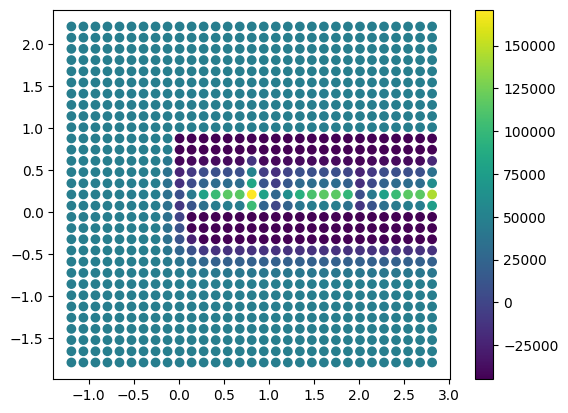

In [9]:
import trimesh

mesh = trimesh.load("identical_rooms_single_mesh.obj")
# mesh = Mesh.from_obj("identical_rooms_single_mesh.obj")
mesh.vertices

TrackedArray([[-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   ,  1.02 ],
              [-1.025,  0.   , -1.   ],
              [-1.025,  0.   , -1.   ],
              [-1.025,  0.   , -1.   ],
              [-1.025, -2.   , -1.   ],
              [-1.025, -2.   , -1.   ],
              [-1.025, -2.   , -1.   ],
              [-1.025, -2.   ,  1.02 ],
              [-1.025, -2.   ,  1.02 ],
              [-1.025, -2.   ,  1.02 ],
              [-1.025, -2.   ,  1.02 ],
              [-3.015, -2.   , -1.   ],
              [-3.015, -2.   , -1.   ],
              [-3.015, -2.   , -1.   ],
              [-3.015,  0.   , -1.   ],
              [-3.015,  0.   , -1.   ],
              [-3.015,  0.   , -1.   ],
              [-3.015, -2.   ,  1.   ],
              [-3.015, -2.   ,  1.   ],
              [-3.015, -2.   ,  1.   ],
              [-3.015,  0.   ,  1.   ],
              [-3.015,  0.   ,  1.   ],


In [4]:
b3d.rr_init("slam")

In [7]:
obj = Mesh.from_obj("identical_rooms_single_mesh.obj")
obj.rr_visualize("mesh")

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'